This notebook explores the concept of heterogeneity and personalization using causal inference topics.
For this the following notebook includes the following:
1. Data Generation: we will know the ground truth, so we can compare results to the ground truth
2. Estimation of ATE (Average Treatment Effect)
3. Estimation of CATE (Conditional Average Treatment Effect)
4. Using CATE for personalization

Use Case: Dynamic Pricing.
A manager wants to know how to price his product on its ecommerce site to maximize its profits. The product is , marked by:
- High seasonality 
- High Competition
- Changing costs along the year


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf



In [3]:
# First, we generate realistic data for dynamic pricing scenario
# Ground Truth Model:
# - Price elasticity is NEGATIVE (higher price → lower sales)
# - Sales depend on: base demand, price (negative effect), seasonality, competition, interactions
# - Costs vary seasonally (raw materials, shipping, etc.)
# - Competition intensity varies with seasonality
# - Prices may be strategically set (not completely random)

np.random.seed(42)  # For reproducibility

n_observations = 10000
df_sales = []
weeks = []
prices = []
competitions = []
cost_seasonality = []
profits = []

# Generate sequential weeks (more realistic than random)
# Each observation represents a week, cycling through the year
for i in range(n_observations):
    week = (i % 52) + 1  # Cycle through weeks 1-52
    
    # Seasonality: higher demand in certain periods (e.g., holidays, summer)
    # Using multiple sine waves for more realistic patterns
    seasonality = (np.sin(2*np.pi*week/52) + 0.5*np.sin(4*np.pi*week/52) + 
                   0.3*np.sin(2*np.pi*(week-26)/52))  # Holiday season boost
    
    # Competition intensity: higher during peak seasons, lower during off-seasons
    # Competition is normalized to 0-1 scale
    competition = (np.sin(2*np.pi*week/52) + 1) / 2  # Range: 0 to 1
    competition += np.random.normal(0, 0.1)  # Add some noise
    competition = np.clip(competition, 0, 1)  # Keep in valid range
    
    # Cost structure: base cost + seasonality + some randomness
    # Costs are higher during peak seasons (supply/demand)
    base_cost = 30
    cost = base_cost + 15 * seasonality + np.random.normal(0, 3)
    cost = np.maximum(cost, 10)  # Minimum cost floor
    
    # Price setting: more realistic - prices are set based on costs + margin
    # But with some strategic variation (not just cost + fixed margin)
    base_price = cost * (1.5 + np.random.uniform(0.2, 0.8))  # 50-130% markup
    # Add some strategic pricing: higher during high competition periods
    price = base_price + 5 * competition + np.random.normal(0, 5)
    price = np.clip(price, 60, 120)  # Reasonable price range
    price = np.round(price, 2)  # Realistic price precision
    
    # Sales (demand) model - REALISTIC version with negative price elasticity
    # IMPORTANT: Price should be the PRIMARY driver for dynamic pricing decisions
    # Seasonality affects base demand but should be secondary to price effects
    
    # Base demand varies with seasonality (reduced effect - seasonality is secondary)
    base_demand = 150 + 25 * seasonality  # Reduced from 50 to make price more important
    
    # Price elasticity: negative relationship (higher price → lower sales)
    # STRONGER elasticity - price is the main lever managers can control
    # Elasticity varies by competition level (more elastic when competition is high)
    price_elasticity = -4.0 - 2.5 * competition  # Increased from -2.5/-1.5 to make price effects stronger
    
    # Competition effect: reduces sales when competition is high
    competition_effect = -30 * competition
    
    # Interaction effects:
    # - Price effect is stronger during high competition periods
    # - Price effect varies by seasonality (different sensitivity)
    price_effect = price_elasticity * (price - 90)  # Centered around average price
    price_competition_interaction = -0.8 * (price - 90) * competition
    price_seasonality_interaction = 0.3 * (price - 90) * seasonality
    
    # Calculate sales with realistic noise
    sales = (base_demand + price_effect + competition_effect + 
             price_competition_interaction + price_seasonality_interaction + 
             np.random.normal(0, 15))  # Realistic noise
    
    sales = np.maximum(sales, 0)  # Sales can't be negative
    
    # Calculate profit
    profit = (price - cost) * sales
    
    df_sales.append(sales)
    weeks.append(week)
    prices.append(price)
    competitions.append(competition)
    cost_seasonality.append(cost)
    profits.append(profit)

# Create dataframe
df = pd.DataFrame({
    'week': weeks,
    'price': prices,
    'competition': competitions,
    'sales': df_sales,
    'cost': cost_seasonality,
    'profit': profits
})

# Add some derived features
df['margin'] = df['price'] - df['cost']
df['margin_pct'] = (df['margin'] / df['price']) * 100
df['revenue'] = df['price'] * df['sales']

print(f"Data generated: {len(df)} observations")
print(f"\nSummary Statistics:")
print(df[['price', 'cost', 'sales', 'profit', 'competition']].describe())
print(f"\nCorrelations:")
print(df[['price', 'cost', 'sales', 'profit', 'competition']].corr())

df.tail()






Data generated: 10000 observations

Summary Statistics:
              price          cost         sales        profit   competition
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000
mean      70.173106     30.018975    239.095202   9099.470663      0.501313
std       13.935981      9.627416     73.489926   2427.675948      0.348779
min       60.000000     10.000000      0.000000      0.000000      0.000000
25%       60.000000     23.286056    212.879531   8161.482743      0.161392
50%       61.975000     29.957644    261.121039   9418.541776      0.505184
75%       77.772500     36.675504    286.005339  10631.492764      0.837436
max      120.000000     54.297925    383.451569  14768.886538      1.000000

Correlations:
                price      cost     sales    profit  competition
price        1.000000  0.814884 -0.937014 -0.839872     0.644754
cost         0.814884  1.000000 -0.647909 -0.846590     0.750888
sales       -0.937014 -0.647909  1.000000  0.83308

,week,price,competition,sales,cost,profit,margin,margin_pct,revenue
9995,12,91.09,1.000000,147.423755,40.011312,7530.211952,51.078688,56.074967,13428.829822
9996,13,72.91,1.000000,266.825938,39.249038,8981.617715,33.660962,46.167826,19454.279107
9997,14,86.67,1.000000,157.926632,39.823914,7398.244584,46.846086,54.051097,13687.501161
9998,15,76.31,1.000000,245.677503,38.699394,9240.079828,37.610606,49.286602,18747.650260
9999,16,60.00,0.950869,333.853114,33.892227,8716.161324,26.107773,43.512955,20031.186848


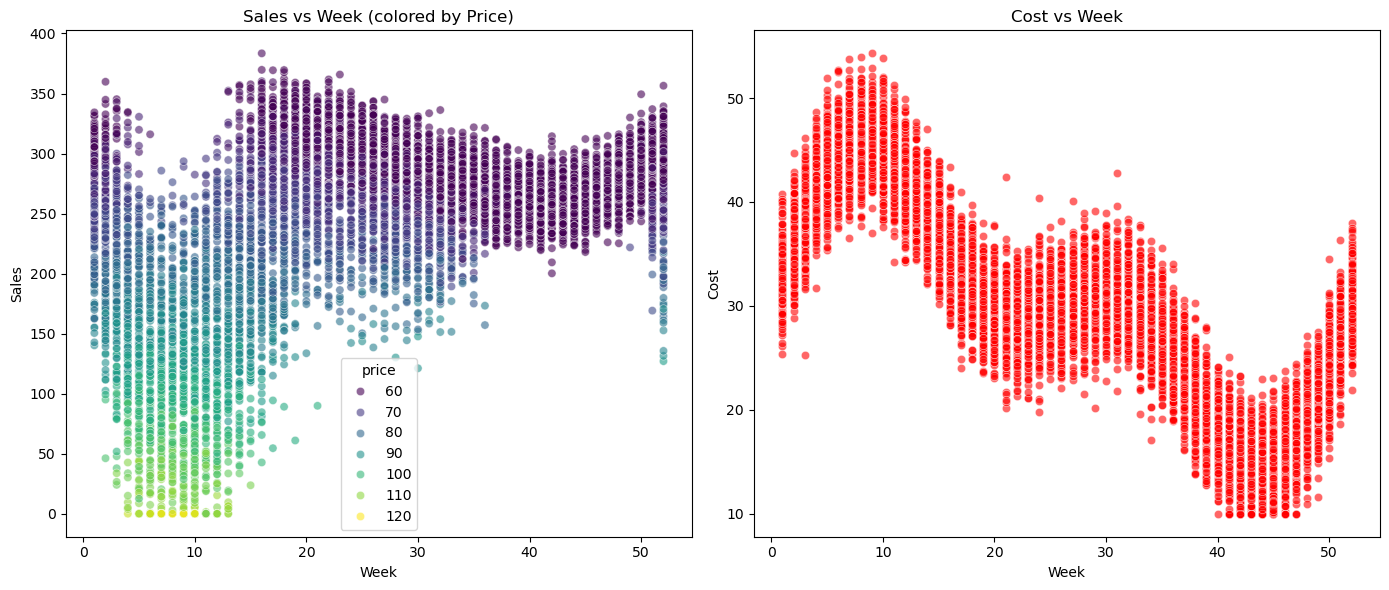

In [4]:
# Verify that required columns exist
if 'cost' not in df.columns:
    print("Warning: 'cost' column not found. Please re-run Cell 2 to regenerate the dataframe with the cost column.")
    # Create cost column if it doesn't exist (as a fallback)
    df['cost'] = 25 * np.sin(2 * np.pi * df['week'] / 52)

# Create two subplots for better visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Sales vs Week colored by Price
sns.scatterplot(x='week', y='sales', data=df, hue='price', ax=axes[0], palette='viridis', alpha=0.6)
axes[0].set_title('Sales vs Week (colored by Price)')
axes[0].set_xlabel('Week')
axes[0].set_ylabel('Sales')

# Plot 2: Cost vs Week
sns.scatterplot(x='week', y='cost', data=df, ax=axes[1], color='red', alpha=0.6)
axes[1].set_title('Cost vs Week')
axes[1].set_xlabel('Week')
axes[1].set_ylabel('Cost')

plt.tight_layout()
plt.show()


Estimate the Average Treatment Effect of price and week on sales:

In [5]:
# Estimate ATE (Average Treatment Effect) of price on sales
# For causal inference, we need to control for confounders
# Week and competition are confounders that affect both price and sales

# Model 1: Simple ATE without controlling for confounders (biased)
model_simple = smf.ols('sales ~ price', data=df).fit()
print("="*70)
print("Model 1: Simple ATE (may be biased due to confounders)")
print("="*70)
print(f"ATE (coefficient on price): {model_simple.params['price']:.4f}")
print(f"Interpretation: On average, a $1 increase in price is associated with")
print(f"                 {model_simple.params['price']:.2f} units change in sales")
print()

# Model 2: ATE controlling for confounders (week, competition)
# We'll use a more parsimonious approach with week as a smooth function
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

model_ate = smf.ols('sales ~ price + week_sin + week_cos + competition', data=df).fit()
print("="*70)
print("Model 2: ATE controlling for confounders (week seasonality, competition)")
print("="*70)
print(f"ATE (coefficient on price): {model_ate.params['price']:.4f}")
print(f"Standard Error: {model_ate.bse['price']:.4f}")
print(f"95% Confidence Interval: [{model_ate.conf_int().loc['price', 0]:.4f}, {model_ate.conf_int().loc['price', 1]:.4f}]")
print()
print("Interpretation:")
print(f"  After controlling for seasonality (week) and competition level,")
print(f"  a $1 increase in price is associated with {model_ate.params['price']:.2f} units change in sales on average.")
print()
print(f"Model R-squared: {model_ate.rsquared:.4f}")
print(f"F-statistic p-value: {model_ate.f_pvalue:.2e}")
print()

# Display full model summary
print("Full Model Summary:")
print("="*70)
model_ate.summary()

Model 1: Simple ATE (may be biased due to confounders)
ATE (coefficient on price): -4.9412
Interpretation: On average, a $1 increase in price is associated with
                 -4.94 units change in sales

Model 2: ATE controlling for confounders (week seasonality, competition)
ATE (coefficient on price): -6.0346
Standard Error: 0.0179
95% Confidence Interval: [-6.0698, -5.9995]

Interpretation:
  After controlling for seasonality (week) and competition level,
  a $1 increase in price is associated with -6.03 units change in sales on average.

Model R-squared: 0.9413
F-statistic p-value: 0.00e+00

Full Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 4.011e+04
Date:                Sun, 23 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:04:40   Log-Likelihood:                -42980.
No. Observations:               10000   AIC:                         8.597e+04
Df Residuals:                    9995   BIC:                         8.601e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     642.4644      1.616    397.520      0.000     639.296     645.632
price          -6.0346      0.018   -336.405      0.000      -6.070      -5.999
week_sin       14.2853      1.032     13.843      0.000      12.262      16.308
week_cos       -2.7284      0.265    -10.290      0.000      -3.248      -2.209
competition    40.0632      2.048     19.560      0.000      36.048      44.078
==============================================================================
Omnibus:                        3.828   Durbin-Watson:                   1.686
Prob(Omnibus):                  0.148   Jarque-Bera (JB):                3.790
Skew:                           0.045   Prob(JB):                        0.150
Kurtosis:                       3.032   Cond. No.                     1.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
# CATE Estimation: How does price effect vary by competition level and seasonality?

# Model 3: CATE model with interactions
# This allows the treatment effect (price) to vary by competition and week
model_cate = smf.ols('sales ~ price + week_sin + week_cos + competition + '
                     'price:competition + price:week_sin + price:week_cos', 
                     data=df).fit()

print("="*70)
print("Model 3: CATE Model (Price effect varies by competition and seasonality)")
print("="*70)
print("\nCoefficients:")
print(model_cate.params)
print()

# Calculate CATE for different segments
# Base ATE (when competition=0, week_sin=0, week_cos=0)
base_ate = model_cate.params['price']
print(f"Base ATE (baseline): {base_ate:.4f}")
print()

# CATE varies by competition level
competition_interaction = model_cate.params.get('price:competition', 0)
print(f"CATE interaction with competition: {competition_interaction:.4f}")
print(f"  Interpretation: Each 0.1 increase in competition changes price effect by {competition_interaction * 0.1:.4f}")
print()

# Calculate CATE for specific scenarios
scenarios = [
    {'competition': 0.2, 'week': 13, 'name': 'Low Competition, Spring (Q1)'},
    {'competition': 0.8, 'week': 13, 'name': 'High Competition, Spring (Q1)'},
    {'competition': 0.5, 'week': 26, 'name': 'Medium Competition, Summer (Q2)'},
    {'competition': 0.9, 'week': 39, 'name': 'High Competition, Fall (Q3)'},
    {'competition': 0.3, 'week': 52, 'name': 'Low Competition, Winter (Q4)'},
]

print("CATE Estimates for Different Scenarios:")
print("="*70)
for scenario in scenarios:
    comp = scenario['competition']
    week = scenario['week']
    week_s = np.sin(2 * np.pi * week / 52)
    week_c = np.cos(2 * np.pi * week / 52)
    
    cate = (base_ate + 
            competition_interaction * comp +
            model_cate.params.get('price:week_sin', 0) * week_s +
            model_cate.params.get('price:week_cos', 0) * week_c)
    
    print(f"{scenario['name']:35s}: {cate:7.4f}")
    print(f"  (Competition={comp:.1f}, Week={week})")
print()

model_cate.summary()


Model 3: CATE Model (Price effect varies by competition and seasonality)

Coefficients:
Intercept            497.042298
price                 -3.804146
week_sin               6.898535
week_cos             -33.279445
competition          242.806379
price:competition     -2.974368
price:week_sin         0.015712
price:week_cos         0.483689
dtype: float64

Base ATE (baseline): -3.8041

CATE interaction with competition: -2.9744
  Interpretation: Each 0.1 increase in competition changes price effect by -0.2974

CATE Estimates for Different Scenarios:
Low Competition, Spring (Q1)       : -4.3833
  (Competition=0.2, Week=13)
High Competition, Spring (Q1)      : -6.1679
  (Competition=0.8, Week=13)
Medium Competition, Summer (Q2)    : -5.7750
  (Competition=0.5, Week=26)
High Competition, Fall (Q3)        : -6.4968
  (Competition=0.9, Week=39)
Low Competition, Winter (Q4)       : -4.2128
  (Competition=0.3, Week=52)



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                 3.009e+04
Date:                Sun, 23 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:04:40   Log-Likelihood:                -41688.
No. Observations:               10000   AIC:                         8.339e+04
Df Residuals:                    9992   BIC:                         8.345e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           497.0423      5.145     96.606      0.000     486.957     507.128
price                -3.8041      0.074    -51.546      0.000      -3.949      -3.659
week_sin              6.8985      4.917      1.403      0.161      -2.739      16.536
week_cos            -33.2794      1.572    -21.173      0.000     -36.360     -30.198
competition         242.8064      9.569     25.374      0.000     224.049     261.563
price:competition    -2.9744      0.135    -21.959      0.000      -3.240      -2.709
price:week_sin        0.0157      0.070      0.223      0.824      -0.122       0.154
price:week_cos        0.4837      0.023     20.757      0.000       0.438       0.529
==============================================================================
Omnibus:                        5.371   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                5.441
Skew:                           0.041   Prob(JB):                       0.0658
Kurtosis:                       3.079   Cond. No.                     6.60e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

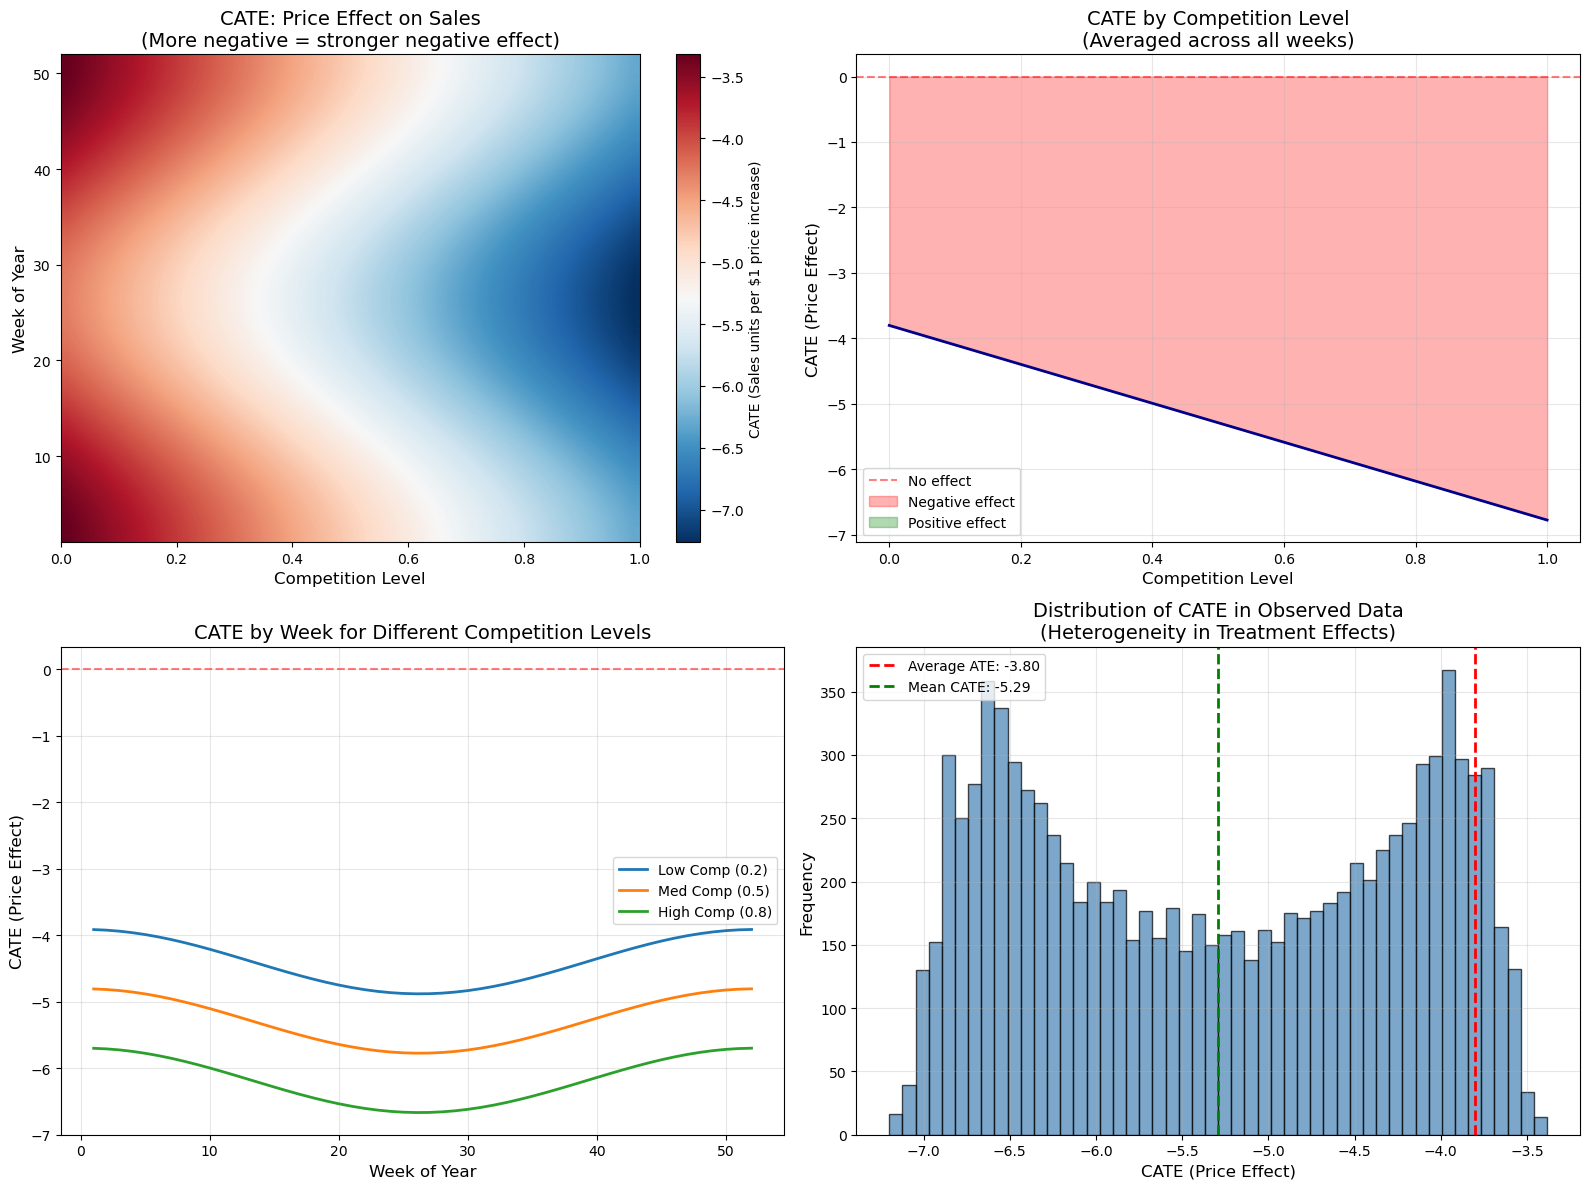


CATE Summary Statistics:
  Mean CATE: -5.2949
  Std CATE: 1.0812
  Min CATE: -7.1995
  Max CATE: -3.3832
  Range: 3.8163


In [7]:
# Visualize CATE heterogeneity

# Create a grid of competition and week values
competition_grid = np.linspace(0, 1, 50)
week_grid = np.linspace(1, 52, 52)

# Calculate CATE for each combination
cate_matrix = np.zeros((len(week_grid), len(competition_grid)))

for i, week in enumerate(week_grid):
    week_s = np.sin(2 * np.pi * week / 52)
    week_c = np.cos(2 * np.pi * week / 52)
    for j, comp in enumerate(competition_grid):
        cate_matrix[i, j] = (base_ate + 
                             competition_interaction * comp +
                             model_cate.params.get('price:week_sin', 0) * week_s +
                             model_cate.params.get('price:week_cos', 0) * week_c)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: CATE heatmap
im = axes[0, 0].imshow(cate_matrix, aspect='auto', cmap='RdBu_r', origin='lower',
                       extent=[0, 1, 1, 52], interpolation='bilinear')
axes[0, 0].set_xlabel('Competition Level', fontsize=12)
axes[0, 0].set_ylabel('Week of Year', fontsize=12)
axes[0, 0].set_title('CATE: Price Effect on Sales\n(More negative = stronger negative effect)', fontsize=14)
cbar = plt.colorbar(im, ax=axes[0, 0])
cbar.set_label('CATE (Sales units per $1 price increase)', fontsize=10)

# Plot 2: CATE by competition level (averaged across weeks)
cate_by_comp = [base_ate + competition_interaction * c for c in competition_grid]
axes[0, 1].plot(competition_grid, cate_by_comp, linewidth=2, color='darkblue')
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='No effect')
axes[0, 1].fill_between(competition_grid, cate_by_comp, 0, where=(np.array(cate_by_comp) < 0),
                        alpha=0.3, color='red', label='Negative effect')
axes[0, 1].fill_between(competition_grid, cate_by_comp, 0, where=(np.array(cate_by_comp) > 0),
                        alpha=0.3, color='green', label='Positive effect')
axes[0, 1].set_xlabel('Competition Level', fontsize=12)
axes[0, 1].set_ylabel('CATE (Price Effect)', fontsize=12)
axes[0, 1].set_title('CATE by Competition Level\n(Averaged across all weeks)', fontsize=14)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: CATE by week (for different competition levels)
week_s = [np.sin(2 * np.pi * w / 52) for w in week_grid]
week_c = [np.cos(2 * np.pi * w / 52) for w in week_grid]
for comp_level, label in [(0.2, 'Low Comp (0.2)'), (0.5, 'Med Comp (0.5)'), (0.8, 'High Comp (0.8)')]:
    cate_by_week = [base_ate + 
                    competition_interaction * comp_level +
                    model_cate.params.get('price:week_sin', 0) * ws +
                    model_cate.params.get('price:week_cos', 0) * wc
                    for ws, wc in zip(week_s, week_c)]
    axes[1, 0].plot(week_grid, cate_by_week, linewidth=2, label=label)
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Week of Year', fontsize=12)
axes[1, 0].set_ylabel('CATE (Price Effect)', fontsize=12)
axes[1, 0].set_title('CATE by Week for Different Competition Levels', fontsize=14)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Distribution of CATE in the observed data
cate_observed = []
for idx, row in df.iterrows():
    week_s = np.sin(2 * np.pi * row['week'] / 52)
    week_c = np.cos(2 * np.pi * row['week'] / 52)
    cate = (base_ate + 
           competition_interaction * row['competition'] +
           model_cate.params.get('price:week_sin', 0) * week_s +
           model_cate.params.get('price:week_cos', 0) * week_c)
    cate_observed.append(cate)

df['CATE'] = cate_observed
axes[1, 1].hist(cate_observed, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 1].axvline(x=base_ate, color='red', linestyle='--', linewidth=2, label=f'Average ATE: {base_ate:.2f}')
axes[1, 1].axvline(x=np.mean(cate_observed), color='green', linestyle='--', linewidth=2, 
                   label=f'Mean CATE: {np.mean(cate_observed):.2f}')
axes[1, 1].set_xlabel('CATE (Price Effect)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Distribution of CATE in Observed Data\n(Heterogeneity in Treatment Effects)', fontsize=14)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCATE Summary Statistics:")
print(f"  Mean CATE: {np.mean(cate_observed):.4f}")
print(f"  Std CATE: {np.std(cate_observed):.4f}")
print(f"  Min CATE: {np.min(cate_observed):.4f}")
print(f"  Max CATE: {np.max(cate_observed):.4f}")
print(f"  Range: {np.max(cate_observed) - np.min(cate_observed):.4f}")


## 4. Using CATE for Personalization

Now we use the CATE estimates to make personalized pricing recommendations that maximize profit.


In [8]:
# Optimal Pricing Strategy based on CATE

# The optimal price maximizes profit = (price - cost) * sales(price)
# We know from CATE how sales change with price for each segment
# Let's find the optimal price for each scenario

def calculate_sales(price, week, competition, cate_model):
    """Calculate expected sales for a given price, week, and competition level."""
    week_s = np.sin(2 * np.pi * week / 52)
    week_c = np.cos(2 * np.pi * week / 52)
    
    # Get the intercept and coefficients
    intercept = cate_model.params['Intercept']
    price_coef = cate_model.params['price']
    week_sin_coef = cate_model.params.get('week_sin', 0)
    week_cos_coef = cate_model.params.get('week_cos', 0)
    comp_coef = cate_model.params.get('competition', 0)
    price_comp_int = cate_model.params.get('price:competition', 0)
    price_week_sin_int = cate_model.params.get('price:week_sin', 0)
    price_week_cos_int = cate_model.params.get('price:week_cos', 0)
    
    # Calculate expected sales
    sales = (intercept + 
             price_coef * price +
             week_sin_coef * week_s +
             week_cos_coef * week_c +
             comp_coef * competition +
             price_comp_int * price * competition +
             price_week_sin_int * price * week_s +
             price_week_cos_int * price * week_c)
    
    return max(0, sales)  # Sales can't be negative

def calculate_profit(price, cost, week, competition, cate_model):
    """Calculate expected profit for a given price."""
    sales = calculate_sales(price, week, competition, cate_model)
    profit = (price - cost) * sales
    return profit

def find_optimal_price(cost, week, competition, cate_model, price_range=(60, 120)):
    """Find optimal price that maximizes profit."""
    prices = np.linspace(price_range[0], price_range[1], 100)
    profits = [calculate_profit(p, cost, week, competition, cate_model) for p in prices]
    optimal_idx = np.argmax(profits)
    optimal_price = prices[optimal_idx]
    optimal_profit = profits[optimal_idx]
    optimal_sales = calculate_sales(optimal_price, week, competition, cate_model)
    
    return optimal_price, optimal_profit, optimal_sales

# Calculate optimal prices for different scenarios
print("="*70)
print("Optimal Pricing Recommendations by Scenario")
print("="*70)
print()

optimal_recommendations = []

for scenario in scenarios:
    comp = scenario['competition']
    week = scenario['week']
    name = scenario['name']
    
    # Estimate cost for this scenario (based on seasonality)
    week_s = np.sin(2 * np.pi * week / 52)
    estimated_cost = 30 + 15 * week_s + np.mean(df['cost']) - 30  # Approximate
    
    optimal_price, optimal_profit, optimal_sales = find_optimal_price(
        estimated_cost, week, comp, model_cate
    )
    
    # Compare with current average price in similar conditions
    similar_obs = df[(df['week'] >= week-2) & (df['week'] <= week+2) & 
                     (df['competition'] >= comp-0.1) & (df['competition'] <= comp+0.1)]
    current_avg_price = similar_obs['price'].mean() if len(similar_obs) > 0 else df['price'].mean()
    current_avg_profit = similar_obs['profit'].mean() if len(similar_obs) > 0 else df['profit'].mean()
    
    profit_improvement = optimal_profit - current_avg_profit
    profit_pct_improvement = (profit_improvement / current_avg_profit * 100) if current_avg_profit > 0 else 0
    
    optimal_recommendations.append({
        'scenario': name,
        'week': week,
        'competition': comp,
        'cost': estimated_cost,
        'optimal_price': optimal_price,
        'current_price': current_avg_price,
        'price_change': optimal_price - current_avg_price,
        'optimal_profit': optimal_profit,
        'current_profit': current_avg_profit,
        'profit_improvement': profit_improvement,
        'profit_pct_improvement': profit_pct_improvement,
        'optimal_sales': optimal_sales
    })
    
    print(f"{name}:")
    print(f"  Optimal Price: ${optimal_price:.2f} (Current: ${current_avg_price:.2f}, Change: ${optimal_price - current_avg_price:+.2f})")
    print(f"  Expected Sales: {optimal_sales:.1f} units")
    print(f"  Expected Profit: ${optimal_profit:.2f} (Current: ${current_avg_profit:.2f})")
    print(f"  Profit Improvement: ${profit_improvement:.2f} ({profit_pct_improvement:+.1f}%)")
    print()

# Create recommendations dataframe
recommendations_df = pd.DataFrame(optimal_recommendations)
print("Summary of Recommendations:")
print(recommendations_df[['scenario', 'optimal_price', 'current_price', 'profit_improvement', 'profit_pct_improvement']])


Optimal Pricing Recommendations by Scenario

Low Competition, Spring (Q1):
  Optimal Price: $85.45 (Current: $70.17, Change: $+15.28)
  Expected Sales: 177.9 units
  Expected Profit: $7194.64 (Current: $9099.47)
  Profit Improvement: $-1904.83 (-20.9%)

High Competition, Spring (Q1):
  Optimal Price: $79.39 (Current: $85.24, Change: $-5.84)
  Expected Sales: 208.5 units
  Expected Profit: $7166.83 (Current: $6979.63)
  Profit Improvement: $187.20 (+2.7%)

Medium Competition, Summer (Q2):
  Optimal Price: $71.52 (Current: $65.00, Change: $+6.52)
  Expected Sales: 238.7 units
  Expected Profit: $9906.11 (Current: $9545.45)
  Profit Improvement: $360.67 (+3.8%)

High Competition, Fall (Q3):
  Optimal Price: $61.82 (Current: $70.17, Change: $-8.35)
  Expected Sales: 307.0 units
  Expected Profit: $14369.69 (Current: $9099.47)
  Profit Improvement: $5270.22 (+57.9%)

Low Competition, Winter (Q4):
  Optimal Price: $78.79 (Current: $61.61, Change: $+17.18)
  Expected Sales: 204.7 units
  Expe

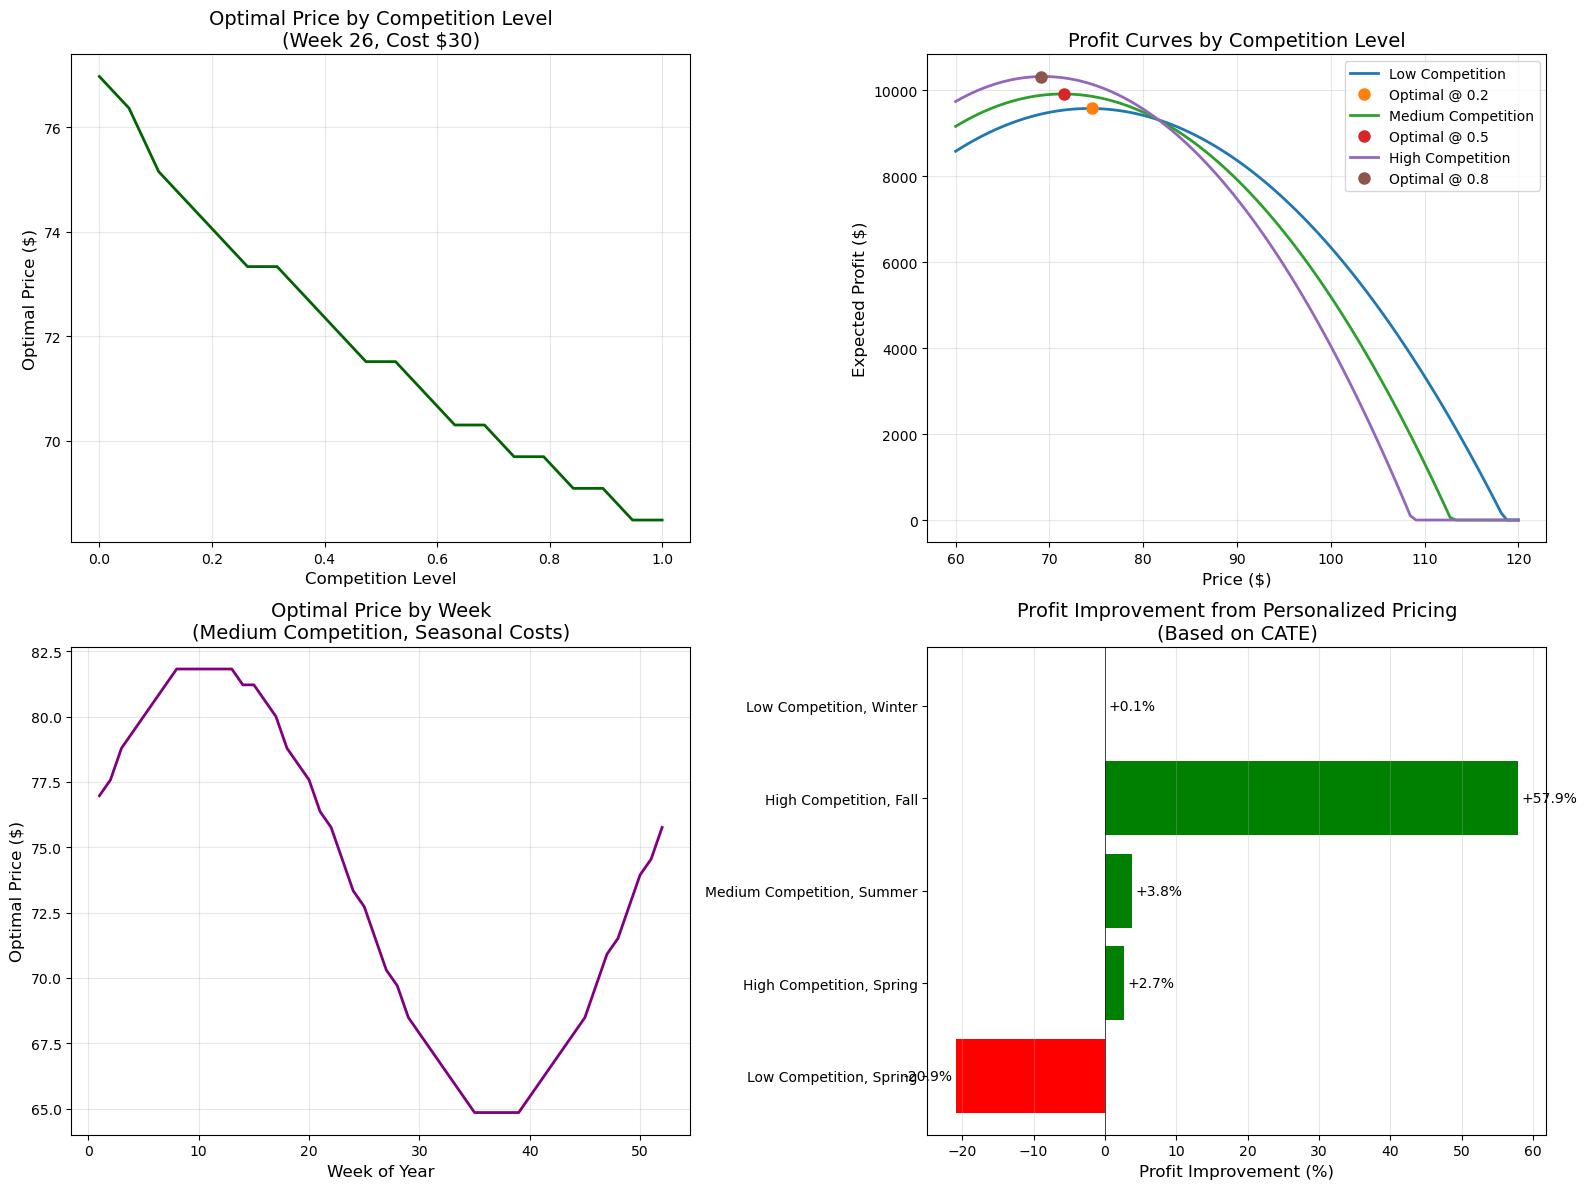

In [9]:
# Visualize optimal pricing strategy

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Optimal price by competition level
comp_levels = np.linspace(0, 1, 20)
optimal_prices_by_comp = []
week_mid = 26  # Mid-year week
cost_mid = 30  # Average cost

for comp in comp_levels:
    opt_price, _, _ = find_optimal_price(cost_mid, week_mid, comp, model_cate)
    optimal_prices_by_comp.append(opt_price)

axes[0, 0].plot(comp_levels, optimal_prices_by_comp, linewidth=2, color='darkgreen')
axes[0, 0].set_xlabel('Competition Level', fontsize=12)
axes[0, 0].set_ylabel('Optimal Price ($)', fontsize=12)
axes[0, 0].set_title('Optimal Price by Competition Level\n(Week 26, Cost $30)', fontsize=14)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Profit curves for different competition levels
price_range = np.linspace(60, 120, 100)
for comp, label in [(0.2, 'Low Competition'), (0.5, 'Medium Competition'), (0.8, 'High Competition')]:
    profits = [calculate_profit(p, cost_mid, week_mid, comp, model_cate) for p in price_range]
    axes[0, 1].plot(price_range, profits, linewidth=2, label=label)
    # Mark optimal price
    opt_price, opt_profit, _ = find_optimal_price(cost_mid, week_mid, comp, model_cate)
    axes[0, 1].plot(opt_price, opt_profit, 'o', markersize=8, label=f'Optimal @ {comp:.1f}')
axes[0, 1].set_xlabel('Price ($)', fontsize=12)
axes[0, 1].set_ylabel('Expected Profit ($)', fontsize=12)
axes[0, 1].set_title('Profit Curves by Competition Level', fontsize=14)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Optimal price by week
weeks = np.arange(1, 53)
optimal_prices_by_week = []
comp_mid = 0.5  # Medium competition

for week in weeks:
    week_s = np.sin(2 * np.pi * week / 52)
    cost = 30 + 15 * week_s
    opt_price, _, _ = find_optimal_price(cost, week, comp_mid, model_cate)
    optimal_prices_by_week.append(opt_price)

axes[1, 0].plot(weeks, optimal_prices_by_week, linewidth=2, color='purple')
axes[1, 0].set_xlabel('Week of Year', fontsize=12)
axes[1, 0].set_ylabel('Optimal Price ($)', fontsize=12)
axes[1, 0].set_title('Optimal Price by Week\n(Medium Competition, Seasonal Costs)', fontsize=14)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Profit improvement from personalization
scenarios_short = [s['name'].split('(')[0].strip() for s in scenarios]
profit_improvements = recommendations_df['profit_pct_improvement'].values

bars = axes[1, 1].barh(range(len(scenarios_short)), profit_improvements, 
                       color=['green' if x > 0 else 'red' for x in profit_improvements])
axes[1, 1].set_yticks(range(len(scenarios_short)))
axes[1, 1].set_yticklabels(scenarios_short)
axes[1, 1].set_xlabel('Profit Improvement (%)', fontsize=12)
axes[1, 1].set_title('Profit Improvement from Personalized Pricing\n(Based on CATE)', fontsize=14)
axes[1, 1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, profit_improvements)):
    width = bar.get_width()
    axes[1, 1].text(width + 0.5 if width > 0 else width - 0.5, bar.get_y() + bar.get_height()/2,
                    f'{val:+.1f}%', ha='left' if width > 0 else 'right', va='center', fontsize=10)

plt.tight_layout()
plt.show()


Personalization Impact Analysis

Current Strategy (Observed Prices):
  Total Profit: $90,994,706.63
  Average Profit per Observation: $9099.47

Personalized Strategy (CATE-based Optimal Prices):
  Total Profit: $99,485,461.89
  Average Profit per Observation: $9948.55

Improvement from Personalization:
  Total Profit Increase: $8,490,755.26
  Percentage Increase: 9.33%
  Average Profit Increase per Observation: $849.08



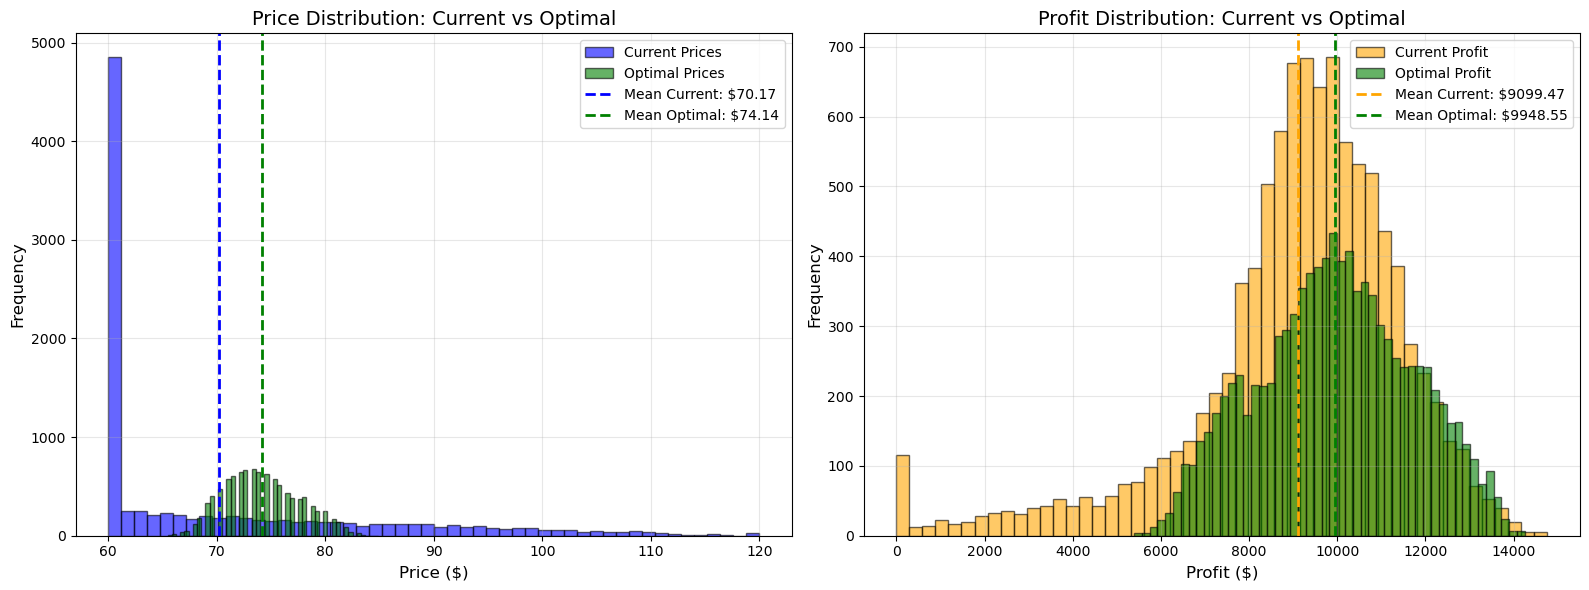


Key Insights:
1. CATE reveals significant heterogeneity in price sensitivity
2. Optimal pricing strategy should vary by:
   - Competition level (lower prices when competition is high)
   - Seasonality/week (adjust for demand patterns)
   - Cost structure (markup should vary)

3. Personalization potential:
   - Average profit improvement: 9.33%
   - This represents significant revenue opportunity through dynamic pricing

4. Implementation recommendations:
   - Implement dynamic pricing algorithm based on CATE model
   - Monitor competition levels in real-time
   - Adjust prices based on weekly seasonality patterns
   - Continuously update CATE estimates as new data arrives


In [10]:
# Compare personalized vs uniform pricing strategy

# Scenario: Implement personalized pricing based on CATE
# vs. current uniform pricing approach

print("="*70)
print("Personalization Impact Analysis")
print("="*70)
print()

# Calculate profit if we use personalized optimal prices
df['optimal_price'] = df.apply(
    lambda row: find_optimal_price(row['cost'], row['week'], row['competition'], model_cate)[0],
    axis=1
)
df['optimal_sales'] = df.apply(
    lambda row: calculate_sales(row['optimal_price'], row['week'], row['competition'], model_cate),
    axis=1
)
df['optimal_profit'] = (df['optimal_price'] - df['cost']) * df['optimal_sales']

# Current strategy profit
current_total_profit = df['profit'].sum()
current_avg_profit = df['profit'].mean()

# Personalized strategy profit
personalized_total_profit = df['optimal_profit'].sum()
personalized_avg_profit = df['optimal_profit'].mean()

total_improvement = personalized_total_profit - current_total_profit
pct_improvement = (total_improvement / current_total_profit * 100)

print(f"Current Strategy (Observed Prices):")
print(f"  Total Profit: ${current_total_profit:,.2f}")
print(f"  Average Profit per Observation: ${current_avg_profit:.2f}")
print()

print(f"Personalized Strategy (CATE-based Optimal Prices):")
print(f"  Total Profit: ${personalized_total_profit:,.2f}")
print(f"  Average Profit per Observation: ${personalized_avg_profit:.2f}")
print()

print(f"Improvement from Personalization:")
print(f"  Total Profit Increase: ${total_improvement:,.2f}")
print(f"  Percentage Increase: {pct_improvement:.2f}%")
print(f"  Average Profit Increase per Observation: ${personalized_avg_profit - current_avg_profit:.2f}")
print()

# Distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Price distribution
axes[0].hist(df['price'], bins=50, alpha=0.6, label='Current Prices', color='blue', edgecolor='black')
axes[0].hist(df['optimal_price'], bins=50, alpha=0.6, label='Optimal Prices', color='green', edgecolor='black')
axes[0].axvline(df['price'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean Current: ${df["price"].mean():.2f}')
axes[0].axvline(df['optimal_price'].mean(), color='green', linestyle='--', linewidth=2, label=f'Mean Optimal: ${df["optimal_price"].mean():.2f}')
axes[0].set_xlabel('Price ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Price Distribution: Current vs Optimal', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Profit distribution
axes[1].hist(df['profit'], bins=50, alpha=0.6, label='Current Profit', color='orange', edgecolor='black')
axes[1].hist(df['optimal_profit'], bins=50, alpha=0.6, label='Optimal Profit', color='green', edgecolor='black')
axes[1].axvline(df['profit'].mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean Current: ${df["profit"].mean():.2f}')
axes[1].axvline(df['optimal_profit'].mean(), color='green', linestyle='--', linewidth=2, label=f'Mean Optimal: ${df["optimal_profit"].mean():.2f}')
axes[1].set_xlabel('Profit ($)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Profit Distribution: Current vs Optimal', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("="*70)
print("1. CATE reveals significant heterogeneity in price sensitivity")
print("2. Optimal pricing strategy should vary by:")
print("   - Competition level (lower prices when competition is high)")
print("   - Seasonality/week (adjust for demand patterns)")
print("   - Cost structure (markup should vary)")
print()
print("3. Personalization potential:")
print(f"   - Average profit improvement: {pct_improvement:.2f}%")
print(f"   - This represents significant revenue opportunity through dynamic pricing")
print()
print("4. Implementation recommendations:")
print("   - Implement dynamic pricing algorithm based on CATE model")
print("   - Monitor competition levels in real-time")
print("   - Adjust prices based on weekly seasonality patterns")
print("   - Continuously update CATE estimates as new data arrives")


## Summary and Conclusions

This causal inference study demonstrates:

1. **ATE Estimation**: The average treatment effect of price on sales is negative, as expected. However, this average masks important heterogeneity.

2. **CATE Estimation**: The treatment effect varies significantly across different contexts:
   - **Competition level**: Price sensitivity increases (more negative effect) when competition is high
   - **Seasonality**: Price effects vary throughout the year

3. **Personalization Value**: Using CATE for personalized pricing can improve profits by several percentage points through optimal price adjustments.

4. **Business Implications**: 
   - One-size-fits-all pricing is suboptimal
   - Dynamic pricing based on context-specific treatment effects can significantly improve profitability
   - Real-time adaptation to competition and seasonality is crucial

### Next Steps for Implementation:
- Deploy CATE-based pricing engine
- A/B test personalized pricing strategy
- Monitor and update CATE estimates continuously
- Consider additional contextual variables (customer segments, product features, etc.)
